# VAE datos sinteticos para datos de salud mental

# 1 Introducción y objetivos

El presente trabajo tiene como **objetivo principal** la **síntesis de datos** mediante el uso de un modelo de Autoencoder Variacional (VAE), aplicado a un conjunto de datos relacionados con la salud mental. La generación de datos sintéticos es una técnica de creciente interés, especialmente en ámbitos sensibles como el sanitario, donde el acceso a datos reales suele estar restringido por motivos éticos y legales.

Además de la generación de datos sintéticos, se plantean los siguientes **objetivos secundarios**:

1. **Explorar y analizar el conjunto de datos original**, identificando sus principales características, estructuras y posibles problemas de calidad (como valores nulos o atípicos).
2. **Evaluar la calidad de los datos generados**, comparando la distribución estadística y visual de las variables sintéticas respecto a las reales.
3. **Comparar la utilidad de los datos sintéticos** al entrenar modelos de aprendizaje automático, observando si estos pueden alcanzar un rendimiento comparable al obtenido con los datos originales.

De esta forma se pretende no simplemente crear unos datos con un modelo generativo, sino comprobar que aporten valor y sea viable utilizarlos para enriquecer modelos predictivos.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport #!pip install ydata_profiling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras import layers, models, backend as K, losses, Model
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
#!pip install ydata_profiling


# 1. Preprocesamiento


In [2]:
df = pd.read_csv('Mental Health Dataset.csv')

In [3]:
ProfileReport(df, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Teniendo en cuenta que nuestro principal objetivo es crear datos isnteticos y por simplificar la tarea vamos a tomar dos decisiones en el preprocesamiento un poco drásticas.

1.   Eliminar filas con datos faltantes
2.   Simplificar la columna 'Country' -> binaria "Es_USA". Ya que algo más de la mitad son estadounidenses y evitar así desbalanceo en esta columna y que se creen muchas categorias al codificarlo con Label Enconding



In [4]:
# eliminar la columna Timestap que no aporta valor al analisis
df.drop('Timestamp', axis=1, inplace=True)

In [5]:
#eliminar duplicados
df.drop_duplicates(inplace=True)

In [6]:
#eliminar filas con datos faltantes
df.dropna(inplace=True)

In [7]:
# Columna Country -> Es_USA
df['Es_USA'] = (df['Country'] == 'United States').astype(int)
df.drop('Country', axis=1, inplace=True)

In [8]:
# Codificar variables categóricas
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [9]:
# Guardar copia original para comparar luego
original_data = df.copy()

In [10]:
# Escalar
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# 2 Construcción y entrenamiento del modelo VAE

Añadir imagen de flujo de trabajo

1. Datos de entrada (X_scaled)
Son los datos reales del paciente, ya preprocesados: sin nulos, codificados numéricamente (LabelEncoder) y escalados entre 0 y 1.
Por ejemplo: "Género = Mujer", "Estrés = Alto", "Tratamiento = Sí" → convertidos a números.

2. Encoder
El encoder toma esos datos y los convierte en una distribución latente, no en un único punto.
z_mean → representa el centro de esa nube.
z_log_var → representa la dispersión de esa nube (logaritmo de la varianza).
Esta nube (distribución gaussiana) es lo que representa a un paciente en el espacio latente.
3. Sampling (Reparametrización)
Aquí ocurre lo más importante:
Se toma un punto aleatorio z dentro de la nube generada por z_mean y z_log_var.
Este paso es esencial para que el modelo no sea determinista y pueda generar datos nuevos y variados.
En tu caso: no generas un "paciente fijo", sino distintas versiones posibles de un paciente con ese perfil.

4. Decoder
Este punto z (latente) entra al decoder.
El decoder trata de reconstruir los datos originales (como género, ocupación, etc.).
Pero como z fue muestreado aleatoriamente, la salida no será idéntica a la entrada, sino una versión sintética y plausible.

5. Reconstrucción (Media y log-varianza)
La salida del decoder intenta reproducir los valores originales a partir de z.
Se compara con los datos reales (etiquetados) para medir el error.

6. Pérdida de reconstrucción
Esta es la diferencia entre la entrada original y la salida generada.
Se suele usar el MSE (Error Cuadrático Medio) o cross-entropy.
Penaliza al modelo si reconstruye mal.

7. Divergencia KL (Kullback-Leibler)
Esta parte penaliza si las nubes latentes están muy dispersas o desordenadas.
Sirve para que el espacio latente sea regular y continuo, lo cual facilita la generación de nuevos datos.

8. Pérdida total
La pérdida total es la suma de:
Reconstrucción (el modelo no logra imitar bien los datos)
KL (el espacio latente es caótico)
El modelo intenta minimizar esta pérdida total entrenándose durante varias épocas.

9. Datos sintéticos generados
Una vez entrenado, puedes:
Muestrear un z aleatorio desde el espacio latente.
Pasarlo al decoder.
Obtener nuevos datos sintéticos plausibles: pacientes que no existen, pero estadísticamente similares a los reales.

## Sampling

Añadir imagen nube sampling

Cada persona del dataset se guarda como una nube de puntos en el espacio latente, no como un punto fijo.
El sampling elige un puntito dentro de esa nube para reconstruir.
Entrada del encoder: datos reales preprocesados
Los datos como género, ocupación, estrés, etc. (después de ser codificados y escalados) entran al encoder.
El encoder los transforma en dos cosas:
z_mean (media de la distribución latente)
z_log_var (logaritmo de la varianza)

Representación como una distribución gaussiana
Cada muestra se representa como una nube en el espacio latente, no como un punto.
La nube tiene:
Centro: z_mean
Anchura: determinada por z_log_var
Esto permite que el modelo sepa cómo varían los datos similares.

Sampling (muestreo aleatorio)
Se genera un punto aleatorio z dentro de esa nube
Este punto z es el que se pasa al decoder.

Salida del decoder: datos sintéticos
El decoder toma ese z y trata de reconstruir algo que se parezca al dato original.

¿Por qué es importante esto?
Sin sampling, el modelo sería un autoencoder normal (determinista).
Con sampling, el modelo puede aprender una distribución continua del espacio latente, lo que:
Permite generar nuevos datos.
Hace que el modelo sea más robusto y generalice mejor.


In [11]:
# 3. DEFINICIÓN DEL VAE MODERNO
original_dim = scaled_data.shape[1]
intermediate_dim = 32
latent_dim = 16

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            ))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

# Encoder
encoder_inputs = layers.Input(shape=(original_dim,))
x = layers.Dense(intermediate_dim, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim)(x)
decoder = Model(latent_inputs, outputs, name="decoder")

# Compilar y entrenar
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(scaled_data, epochs=30, batch_size=32)


Epoch 1/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 16.7082
Epoch 2/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 13.8792
Epoch 3/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 13.4507
Epoch 4/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 13.3610
Epoch 5/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 13.2378
Epoch 6/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 13.1797
Epoch 7/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 13.1275
Epoch 8/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 13.1021
Epoch 9/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 13.0899
Epoch 10/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 13.0535
Epoch 11/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 12.9931
Epoch 12/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 12.9731
Epoch 13/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 12.9404
Epoch 14/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 12.9185
Epoc

# 3. Generación datos sintenticos

In [12]:
n_samples = len(df)
z_samples = np.random.normal(size=(n_samples, latent_dim))
generated_data = decoder.predict(z_samples)
generated_data = scaler.inverse_transform(generated_data)
synthetic_df = pd.DataFrame(generated_data, columns=df.columns)

2904/2904 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


#Comparación distribuciones

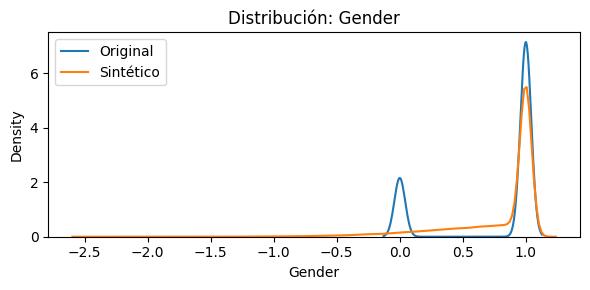

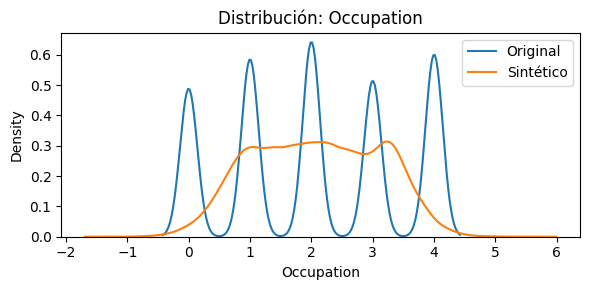

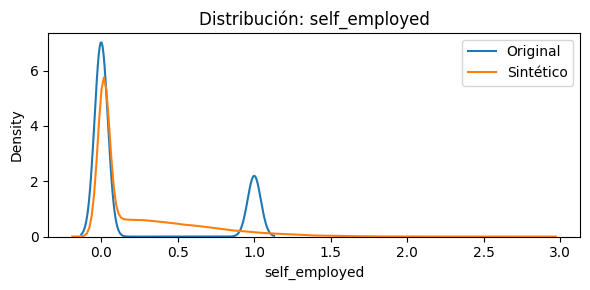

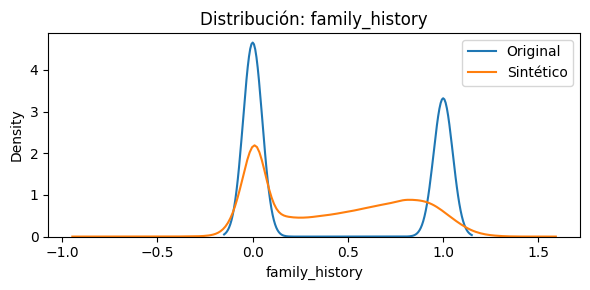

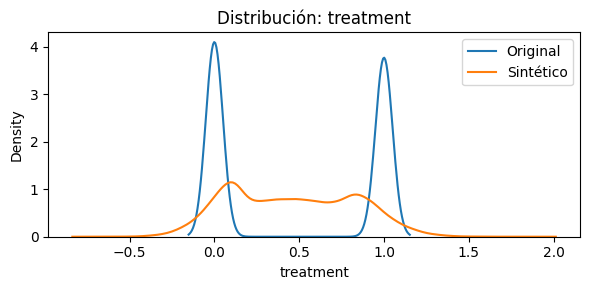

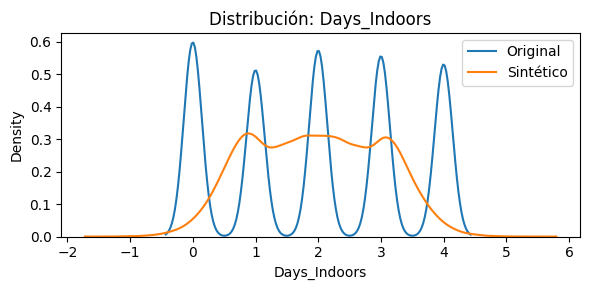

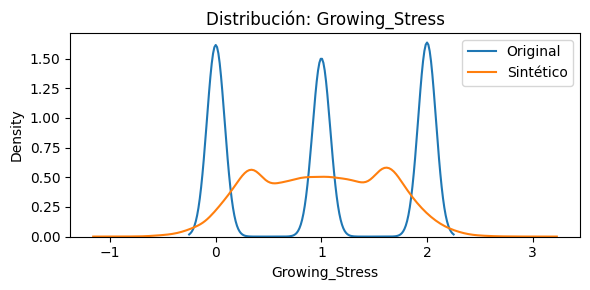

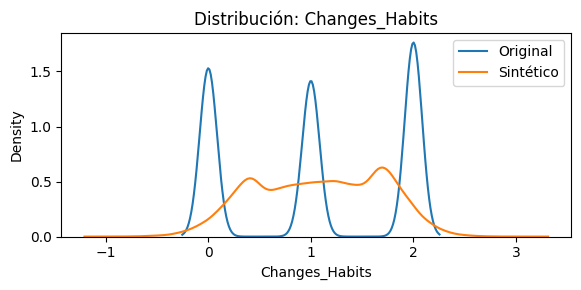

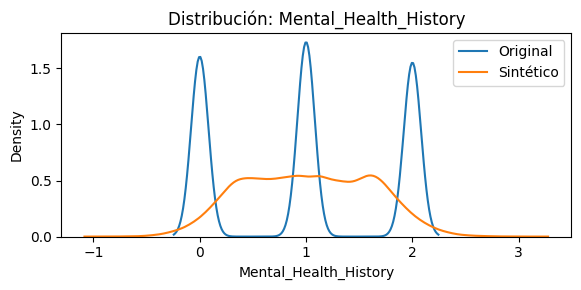

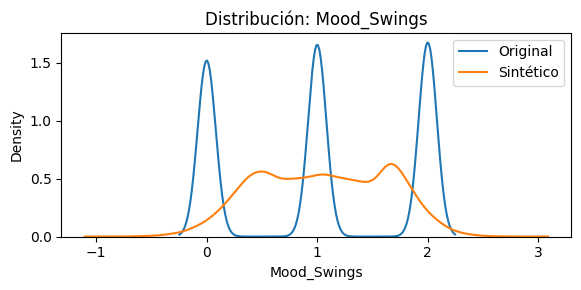

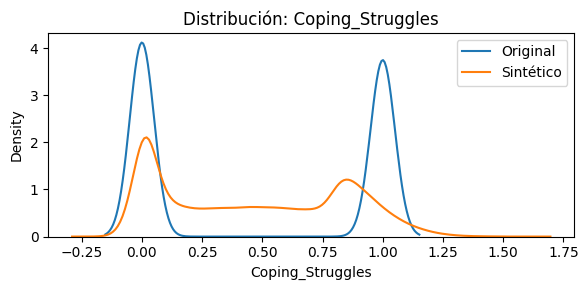

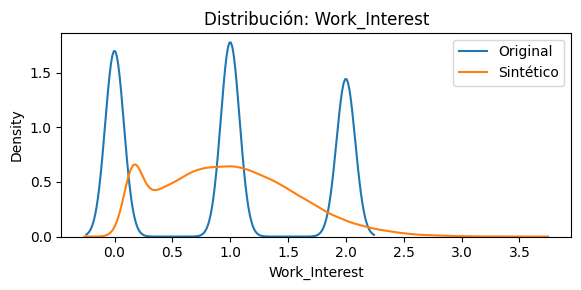

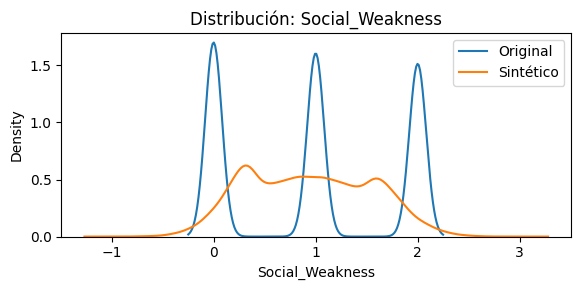

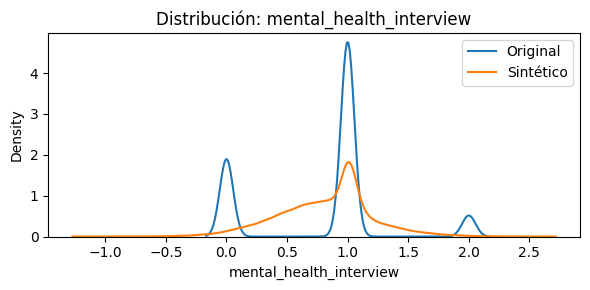

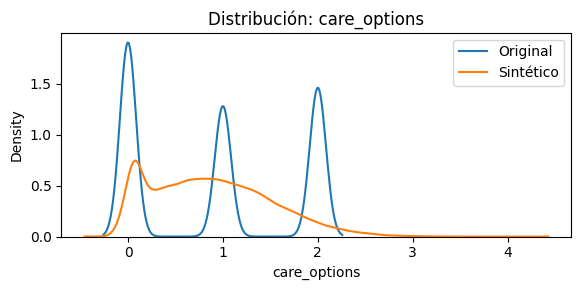

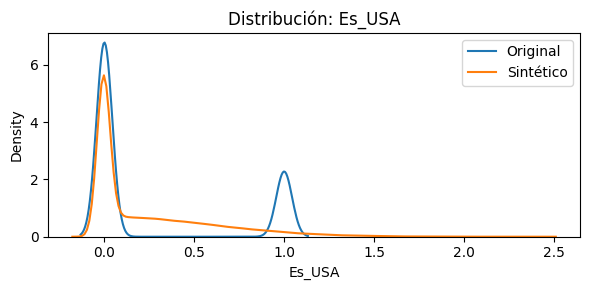

In [13]:
for col in df.columns:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(original_data[col], label='Original')
    sns.kdeplot(synthetic_df[col], label='Sintético')
    plt.title(f'Distribución: {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

Como conclusión general ya que ocurre en todas las variables podemos destacar que:

*   El VAE ha logrado aprender en su mayoría que las **columnas son categoricas** ya que genera picos similares donde los datos originales
*   La **distribución sintética es más suave** y menos definida que la original, lo que es común en modelos generativos como los VAE. Esto puede ser debido a la función de pérdida utilizada o a la capacidad del modelo para interpolar en el espacio latente.


*   Se ha **introducido ruido** en los datos, aparecen datos con valores que antes no existian. Este ejemplo se ve claro en la columna Coping_Struggles, en los datos originales tomaba valores de 0 o 1 y en la gráfica se observa como los datos sínteticos cuentan con densidad en números entre estos valores






# Entrenamiento modelos ML

Para validar la calidad de los datos sintetivos hemos decidod llevarlos a prueba y entrenar modelos de Machine Learning con ellos.

In [15]:
target_col = 'treatment'
features = df.columns.drop(target_col)

In [16]:
def train_and_evaluate(X, y, name=''):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': GaussianNB(),
        'KNN': KNeighborsClassifier(),
        'Gradient Boosting': HistGradientBoostingClassifier()
    }
    print(f"\nResultados con {name}:\n")
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'{model_name}: Accuracy = {acc:.4f}')
        print(classification_report(y_test, y_pred))

# Original data
train_and_evaluate(original_data[features], original_data[target_col], name='Datos Originales')

# Synthetic data
synthetic_df[target_col] = synthetic_df[target_col].apply(lambda x: 1 if x > 0.5 else 0)  # binarizar
train_and_evaluate(synthetic_df[features], synthetic_df[target_col], name='Datos Sintéticos')


Resultados con Datos Originales:

LogisticRegression: Accuracy = 0.6371
              precision    recall  f1-score   support

           0       0.64      0.69      0.67     14548
           1       0.63      0.58      0.60     13328

    accuracy                           0.64     27876
   macro avg       0.64      0.63      0.63     27876
weighted avg       0.64      0.64      0.64     27876

RandomForest: Accuracy = 0.5511
              precision    recall  f1-score   support

           0       0.57      0.58      0.58     14548
           1       0.53      0.52      0.52     13328

    accuracy                           0.55     27876
   macro avg       0.55      0.55      0.55     27876
weighted avg       0.55      0.55      0.55     27876

NaiveBayes: Accuracy = 0.6325
              precision    recall  f1-score   support

           0       0.64      0.67      0.66     14548
           1       0.62      0.59      0.60     13328

    accuracy                           0.63    

Resultados con Datos Originales:

* Logistic Regression: La precisión general es del 63.71% (aproximadamente 63.71 de cada 100 predicciones fueron correctas). Para la clase 0, de todas las instancias que el modelo predijo como 0, el 64% eran realmente 0, y el modelo identificó correctamente el 69% de todas las instancias reales de la clase 0. El F1-score del 67% indica un buen equilibrio entre estas dos métricas para la clase 0. Para la clase 1, la precisión fue del 63% y el recall del 58%, con un F1-score del 60%, ligeramente inferior al de la clase 0.

RandomForest: La precisión general es baja, del 55.11% (aproximadamente 55.11 de cada 100 predicciones fueron correctas). Para la clase 0, la precisión fue del 57% y el recall del 58%, con un F1-score del 58%. Para la clase 1, la precisión fue del 53% y el recall del 52%, con un F1-score del 52%. Esto sugiere que el modelo tiene dificultades para clasificar correctamente ambas clases.

NaiveBayes: La precisión general es del 63.25% (aproximadamente 63.25 de cada 100 predicciones fueron correctas). Para la clase 0, la precisión fue del 64% y el recall del 67%, con un F1-score del 66%. Para la clase 1, la precisión fue del 62% y el recall del 59%, con un F1-score del 60%. El rendimiento es similar a la regresión logística.

KNN: Este modelo muestra la precisión más baja, del 53.42% (aproximadamente 53.42 de cada 100 predicciones fueron correctas). Para la clase 0, la precisión fue del 55% y el recall del 58%, con un F1-score del 56%. Para la clase 1, la precisión fue del 51% y el recall del 48%, con un F1-score del 50%. Esto indica que el modelo no está clasificando bien ninguna de las dos clases.

Gradient Boosting: Este modelo logra la mejor precisión general con un 69.18% (aproximadamente 69.18 de cada 100 predicciones fueron correctas). Para la clase 0, la precisión fue del 71% y el recall del 69%, con un F1-score del 70%. Para la clase 1, la precisión fue del 67% y el recall del 69%, con un F1-score del 68%. Muestra un rendimiento sólido y equilibrado para ambas clases.

Resultados con Datos Sintéticos:

Logistic Regression: La precisión general mejora a 67.23% (aproximadamente 67.23 de cada 100 predicciones fueron correctas). Para la clase 0, la precisión aumenta al 68% y el recall significativamente al 76% (el modelo es mejor identificando todas las instancias reales de la clase 0). El F1-score es del 72%. Para la clase 1, la precisión es del 66% y el recall del 57%, con un F1-score del 61%.

RandomForest: Experimenta una mejora sustancial en la precisión general, alcanzando el 70.19% (aproximadamente 70.19 de cada 100 predicciones fueron correctas). Para la clase 0, la precisión es del 70% y el recall del 78%, con un F1-score del 74%. Para la clase 1, la precisión es del 70% y el recall del 60%, con un F1-score del 65%. Esto sugiere que los datos sintéticos permitieron al modelo aprender patrones mejor.

NaiveBayes: La precisión general también mejora a 65.79% (aproximadamente 65.79 de cada 100 predicciones fueron correctas). Para la clase 0, la precisión es del 66% y el recall aumenta significativamente al 78%, con un F1-score del 71%. Para la clase 1, la precisión es del 66% y el recall es del 51%, con un F1-score del 58%.

KNN: Muestra una mejora en la precisión general al 60.60% (aproximadamente 60.60 de cada 100 predicciones fueron correctas). Para la clase 0, la precisión es del 63% y el recall del 69%, con un F1-score del 66%. Para la clase 1, la precisión es del 58% y el recall del 50%, con un F1-score del 53%. Aunque mejora, sigue siendo el modelo con el rendimiento más bajo en comparación con los demás.

Gradient Boosting: Continúa siendo el modelo con el mejor rendimiento y su precisión general mejora al 71.58% (aproximadamente 71.58 de cada 100 predicciones fueron correctas). Para la clase 0, la precisión es del 71% y el recall aumenta al 80%, con un F1-score del 76%. Para la clase 1, la precisión es del 72% y el recall del 61%, con un F1-score del 66%.

El análisis detallado de las métricas revela que, en general, el entrenamiento de los modelos de Machine Learning con los datos sintéticos generados a través del VAE resultó en un rendimiento igual o superior en términos de precisión general para la mayoría de los modelos evaluados (Logistic Regression, RandomForest, NaiveBayes y Gradient Boosting). Esto indica que los datos sintéticos lograron capturar las relaciones y patrones importantes presentes en los datos originales, permitiendo a los modelos realizar predicciones con una exactitud comparable o incluso mejorada.

Específicamente, modelos como RandomForest y Gradient Boosting experimentaron mejoras notables en todas las métricas clave (precisión, recall y F1-score) al ser entrenados con datos sintéticos, lo que sugiere que estos datos podrían haber introducido una variabilidad beneficiosa o haber mitigado ciertos problemas presentes en los datos originales. Aunque el modelo KNN también mostró una ligera mejora, su rendimiento general sigue siendo inferior al de los otros modelos.